# Detecting similarity in Quora questions
This notebook details and implements our approach to the challenge of detecting the similarity between two randomly sampled questions.



In [5]:
# For interacting with the JNResearch API
from api_client import ApiClient
# Data processing
import pandas as pd
import numpy as np
import json
from time import time
import os
# NLP preprocessing
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
# Machine learning 
import tensorflow.keras as keras
from keras.layers import Input,Embedding,Dense,GRU,Concatenate, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
# Plotting and analysis
import matplotlib.pyplot as plt

/Users/ankit/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/ankit/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Setup

This ensures that the output directory exists. The later code will place its outputs in this directory.

In [9]:
try:
    os.mkdir('./outputs')
except FileExistsError:
    pass

We define a few constants here. These control the flow of execution and a few model paramters.

In [ ]:
MAX_LEN=100 # Max length of an input question
DATA_SIZE=15000 # Set to <= 0 to read full data
EPOCHS=7
HIDDEN_UNITS=50
COMPLEX_MODE=False # Set to true to run the complex model as well

## Utility functions
This function loads the downloaded GloVe embeddings file.
It returns a dictionary that maps words to indices, and a matrix of corrosponding vectors.
This matrix will be used to create the embedding layer later

In [7]:
def get_embeddings():
    embeddings = open('glove.6B/glove.6B.50d.txt').readlines()
    words = []
    vectors = []
    for row in embeddings:
        x = row.split(" ")
        words.append(x[0])
        vectors.append([float(x[i]) for i in range(1,len(x))])

    default_vector = [0 for _ in range(len(vectors[0]))]
    vectors.insert(0,default_vector)
    vectors = np.array(vectors)
    # Map words to index(reverse list mapping)
    word_dict = {}
    for i,word in enumerate(words):
        word_dict[word] = i+1
    
    return word_dict, vectors

word_dict,vectors = get_embeddings()

This function loads data from a csv file (produced by another notebook). 
It produces usable training and testing data.

In [ ]:
def get_data():
    if DATA_SIZE > 0:
        data=pd.read_csv('quora.csv', nrows=15000)
    else:
        data=pd.read_csv('quora.csv')
        
    def process_question(sentence):
        try: # Something in the input data trips up nltk somehow
            words = word_tokenize(sentence)
        except: # Naivity to the rescue!
            words = sentence.split(" ")
            
        words = [word_dict.get(word,0) for word in words]
        return np.array(pad_sequences(np.array([words]),maxlen=MAX_LEN)[0])

    data['question1'] = data['question1'].apply(process_question)
    data['question2'] = data['question2'].apply(process_question)

    train,test = train_test_split(data,test_size=0.15)

    def extract(data):
        return {
            'left':np.stack(data['question1'],axis=0),
            'right':np.stack(data['question2'],axis=0)
        }, data['is_duplicate'].values

    train_X,train_Y = extract(train)
    test_X,test_Y = extract(test)
    
    print(data.head())
    return train_X,train_Y,test_X,test_Y
    
    
    
train_X,train_Y,test_X,test_Y = get_data()


This function generates statistics for a model. It takes a history object (returned from the model.fit() function) and produces a set of charts and a text summary of the training process.

In [46]:
def generate_stats(history,prefix='model'):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    fig = plt.figure(figsize=(10,10))
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)
    plt.subplot(3,1,1)
    plt.title('Loss')
    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'r-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.ylabel('Loss')
    plt.subplot(3,1,2)
    plt.title('MSE')
    plt.plot(epoch_count, history.history['mean_squared_error'], 'b--')
    plt.plot(epoch_count, history.history['val_mean_squared_error'], 'b-')
    plt.legend(['Training MSE', 'Test MSE'])
    plt.ylabel('MSE')
    
    plt.subplot(3,1,3)
    plt.title('Accuracy')
    plt.plot(epoch_count, history.history['binary_accuracy'], 'g--')
    plt.plot(epoch_count, history.history['val_binary_accuracy'],'g-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.savefig('./outputs/{}_stats.png'.format(prefix))
    plt.show()
    f = open('./outputs/{}_report.txt'.format(prefix),'w')
    f.write("Trained over {} samples for {} epochs (batch size {})\n".format(
    history.params['samples'],history.params['epochs'],history.params['batch_size']))
    f.write("final validation accuracy: {}".format(history.history['val_binary_accuracy'][-1]))


## The models
This function produces the basic model.

In [43]:
def get_model():
    left = Input(shape=(MAX_LEN,),dtype='int32', name='left')
    right = Input(shape=(MAX_LEN,),dtype='int32', name='right')
    embedding_layer = Embedding(len(vectors), 50, weights=[vectors],input_length=MAX_LEN, trainable=False,name="Glove")

    embed_left = embedding_layer(left)
    embed_right = embedding_layer(right)

    gru_layer = GRU(HIDDEN_UNITS)

    left_vector = gru_layer(embed_left)
    right_vector = gru_layer(embed_right)

    final_vector = Concatenate()([left_vector,right_vector])
    l = final_vector
    l = Dense(50,activation='relu')(l)
    is_duplicate = Dense(1,activation='sigmoid',name='is_duplicate')(l)

    model = Model(inputs=[left,right],outputs=[is_duplicate])
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse','binary_accuracy'])
    return model



This function produces an alternate, more complicated model. We do not currently use it.

In [44]:
def get_complex_model():
    left = Input(shape=(MAX_LEN,),dtype='int32', name='left')
    right = Input(shape=(MAX_LEN,),dtype='int32', name='right')
    embedding_layer = Embedding(len(vectors), 50, weights=[vectors],input_length=MAX_LEN, trainable=False,name="Glove")

    embed_left = embedding_layer(left)
    embed_right = embedding_layer(right)

    gru_layer = GRU(HIDDEN_UNITS)

    left_vector = gru_layer(embed_left)
    right_vector = gru_layer(embed_right)

    final_vector = Concatenate()([left_vector,right_vector])
    l = final_vector
    l = Dropout(0.3)(l)
    l = Dense(100,activation='relu')(l)
    l = BatchNormalization()(l)
    l = Dense(50,activation='relu')(l)
    l = Dropout(0.2)(l)
    l = Dense(30,activation='relu')(l)
    l = BatchNormalization()(l)
    is_duplicate = Dense(1,activation='sigmoid',name='is_duplicate')(l)

    model = Model(inputs=[left,right],outputs=[is_duplicate])
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse','binary_accuracy'])
    return model


## Running
This cell contains the main driver code. It generates the model, produces a YAML summary, produces a layer graph, trains it, and finally generates statistics.
Note that this will not preserve the weights of the model across runs. Move the model creation outside the cell if you want that.

Train on 12750 samples, validate on 2250 samples
Epoch 1/7
12750/12750 [==============================] - 59s - loss: 0.6357 - mean_squared_error: 0.2227 - binary_accuracy: 0.6478 - val_loss: 0.6123 - val_mean_squared_error: 0.2124 - val_binary_accuracy: 0.6582
Epoch 2/7
12750/12750 [==============================] - 50s - loss: 0.5867 - mean_squared_error: 0.2016 - binary_accuracy: 0.6877 - val_loss: 0.5824 - val_mean_squared_error: 0.1996 - val_binary_accuracy: 0.6916
Epoch 3/7
12750/12750 [==============================] - 49s - loss: 0.5633 - mean_squared_error: 0.1917 - binary_accuracy: 0.7035 - val_loss: 0.5723 - val_mean_squared_error: 0.1954 - val_binary_accuracy: 0.7000
Epoch 4/7
12750/12750 [==============================] - 56s - loss: 0.5432 - mean_squared_error: 0.1833 - binary_accuracy: 0.7216 - val_loss: 0.5766 - val_mean_squared_error: 0.1969 - val_binary_accuracy: 0.6960
Epoch 5/7
12750/12750 [==============================] - 55s - loss: 0.5204 - mean_squared_error: 0

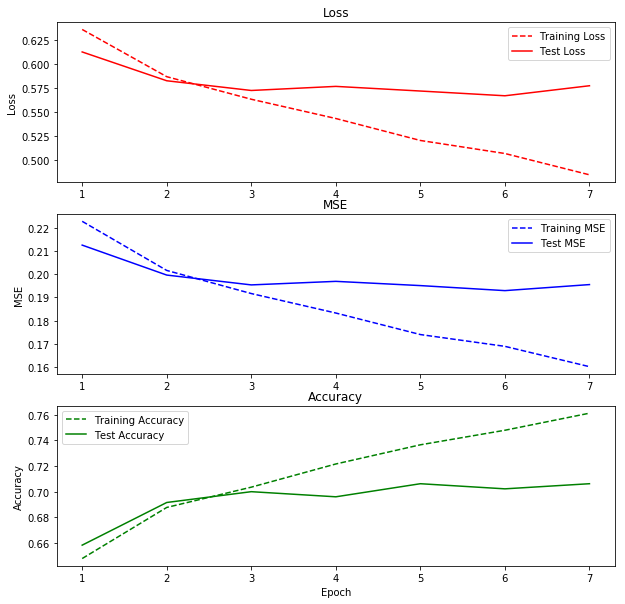

In [47]:
model = get_model()
open('./outputs/model_description.yaml','w').write(model.to_yaml())
plot_model(model, to_file='./outputs/model_graph.png',show_layer_names=True,show_shapes=True)
history = model.fit(train_X,train_Y,validation_data=[test_X,test_Y],epochs=7)
generate_stats(history,prefix='simple')

This cell contains unused driver code for the complex mode. The code is analogous to the above cell.

In [ ]:
if COMPLEX_MODE:
    model = get_complex_model()
    open('./outputs/model_description.yaml','w').write(model.to_yaml())
    plot_model(model, to_file='./outputs/complex_model_graph.png',show_layer_names=True,show_shapes=True)
    history = model.fit(train_X,train_Y,validation_data=[test_X,test_Y],epochs=7)
    generate_stats(history,prefix='complex')
    open('./outputs/complex_model_description.yaml','w').write(model.to_yaml())